In [2]:
import os
import cv2
from time import time
import numpy as np
import quaternion
from IPython.display import clear_output
from vo_modules_new import VisualOdometry as VO
from scipy.spatial.transform import Rotation as R
from libs.general.utils import *
from libs.utils import load_kitti_odom_intrinsics
from tqdm import tqdm as tqdm_
import matplotlib.pyplot as plt
from arguments import init_config
from env import Env
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import importlib
import vo_modules_new
importlib.reload(vo_modules_new)
from vo_modules_new import VisualOdometry as VO

# Custom config: (CHANGE IF NEEDED)
config_file = "options/custom_configuration_new.yml"

default_config_file = "options/kitti/kitti_default_configuration.yml"
config_files = [default_config_file, config_file]
cfg = merge_cfg(config_files)
cfg.seq = str(cfg.seq)
cfg.available.gt_pose = False

# Random seed
SEED = cfg.seed
np.random.seed(SEED)

In [5]:
config = init_config()
config.defrost()
#config.SIMULATOR.HABITAT_SIM_V0.ALLOW_SLIDING = True
config.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS.intensity_constant = 0.1  # 0.1
config.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 0.5  # 0.5
config.SIMULATOR.TURN_ANGLE = 10  # 10
config.SIMULATOR.TILT_ANGLE = 10  # 10
config.SIMULATOR.FORWARD_STEP_SIZE = 0.25  # 0.25
config.freeze()
config['DATASET']['SPLIT'] = 'train'
env = Env(config=config)

2020-06-17 13:37:38,358 Initializing dataset PointNav-v1
Initializing dataset PointNav-v1
2020-06-17 13:39:38,610 initializing sim Sim-v0
initializing sim Sim-v0
2020-06-17 13:39:44,905 Initializing task Nav-v0
Initializing task Nav-v0


In [13]:
done = False
img_id = 0
observations, info, done = env.reset(50)

# init VO
vo = VO(cfg)
vo.setup()
vo.gt_poses = {0.0: np.array([[ 0.22485091,  0.        ,  0.97439318,  0.        ],
                               [ 0.        ,  1.        ,  0.        ,  0.        ],
                               [-0.97439318,  0.        ,  0.22485091,  0.        ],
                               [ 0.        ,  0.        ,  0.        ,  1.        ]])}

==> Precomputed depths: depth network not active
==> initialize LiteFlowNet with [model/network-default.pytorch]


In [14]:
gt_pose = []
while not done:
    observations, info, done = env.step(2, ideal_action=True)
    gt_pose.append([env.trux,env.truy])
    vo.step(observations['rgb'], observations['depth'][:,:,0])

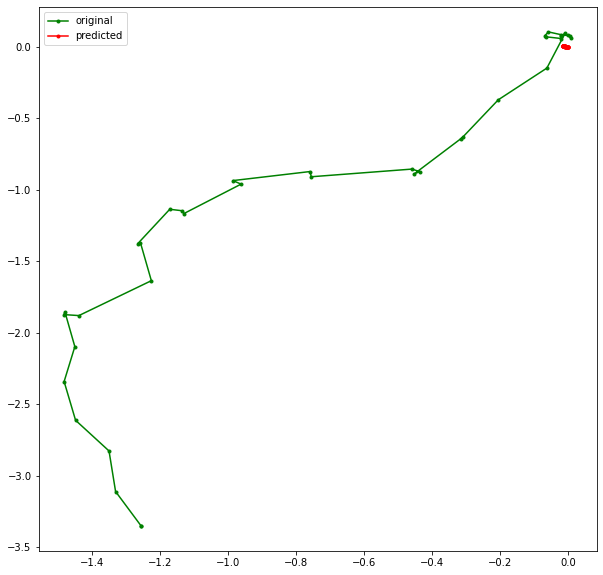

In [18]:
vo.draw_traj(gt_pose=gt_pose)

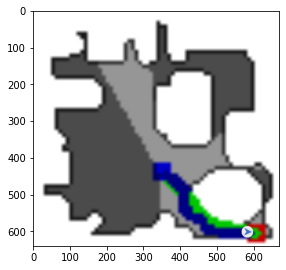

In [16]:
from utils import draw_top_down_map
top_down_map = draw_top_down_map(info, observations["heading"][0], observations['rgb'][0].shape[0])
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(231)
ax.imshow(top_down_map)